## Importando as bibliotecas

In [92]:
# Manipulação de dados
import pandas as pd
import numpy as np
import re
from collections import defaultdict
import requests

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Pré-processamento de dados
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

# Métricas de avaliação
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import linear_kernel

# Processamento de linguagem natural (NLP)
import nltk
nltk.download('stopwords')
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer

# Utilitários e tratamento de warnings
import random
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignorar avisos de convergência
warnings.filterwarnings("ignore", category=ConvergenceWarning)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Tratando o dataset

In [10]:
df = pd.read_csv('archive/spam.csv', encoding='ISO-8859-1')
df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
df = df[df['label'].isin(['ham', 'spam'])]
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

In [11]:
df

,label,text,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will Ì_ b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


## Pré-processamento dos dados

In [14]:
# Stemmed text
df_stemmed = df.copy()

stemmer = SnowballStemmer("english")
df_stemmed['text'] = df_stemmed['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [16]:
# Lemmatized text
df_lemmatized = df.copy()

lemmatizer = WordNetLemmatizer()
df_lemmatized['text'] = df_lemmatized['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos='v') for word in x.split()]))

In [20]:
# Stopwords removal

df_no_stopwords = df.copy()

stopwords = nltk.corpus.stopwords.words('english')
df_no_stopwords['text'] = df_no_stopwords['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stopwords]))

## Criando o modelo

In [31]:
def build_pipeline(vectorizer, transformer, classifier):
    """
    Constrói o pipeline com as etapas de vetorização, transformação e classificação.
    
    :param vectorizer: Vetorizador (ex: CountVectorizer, TfidfVectorizer)
    :param transformer: Transformer (ex: NMF, PCA, ou None)
    :param classifier: Classificador (ex: BernoulliNB, LogisticRegression)
    
    :return: Pipeline configurado
    """
    steps = [('vectorizer', vectorizer)]
    
    if transformer:
        steps.append(('transformer', transformer))
    
    steps.append(('classifier', classifier))
    
    return Pipeline(steps)

def model_evaluation(df, vectorizer, transformer, classifier, n_repeats=20, n_splits=5, random_state=42):
    """
    Avalia um modelo utilizando validação cruzada repetida com diferentes vetorizadores, transformadores e classificadores.
    
    :param df: DataFrame contendo as colunas 'text' e 'label'
    :param vectorizer: Vetorizador (ex: CountVectorizer, TfidfVectorizer)
    :param transformer: Transformer (ex: NMF, PCA, ou None)
    :param classifier: Classificador (ex: BernoulliNB, LogisticRegression)
    :param n_repeats: Número de repetições da validação cruzada
    :param n_splits: Número de splits (folds) na validação cruzada
    :param random_state: Semente aleatória para garantir repetibilidade
    
    :return: Média e desvio padrão da acurácia
    """
    
    X = vectorizer.fit_transform(df['text'])
    y = df['label']
    
    if transformer:
        X = transformer.fit_transform(X)
    
    rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    
    accuracies = cross_val_score(classifier, X, y, cv=rskf, scoring='accuracy')
    
    return classifier, np.mean(accuracies), np.std(accuracies)

def predict_email(model, email_text, threshold=0.85):
    """
    Preve se o email é spam ou não com base no modelo treinado, usando um threshold de confiança.
    
    :param model: O modelo treinado
    :param email_text: O conteúdo do email como string
    :param threshold: A confiança mínima para classificar como spam (valor entre 0 e 1)
    :return: Previsão do modelo (1 = spam, 0 = não-spam) com probabilidade
    """
    for email in email_text:
        # Obter a probabilidade da classe 1 (spam)
        proba = model.predict_proba([email])[0][1]
        
        # Se a probabilidade for maior que o threshold, classifica como SPAM
        if proba >= threshold:
            print(f"SPAM (Probabilidade: {proba:.2f})")
        else:
            print(f"NÃO é SPAM (Probabilidade: {proba:.2f})")


In [32]:
# Lista de DataFrames (df_stemmed, df_lemmatized, df_no_stopwords)
dataframes = {
    'Stemmed': df_stemmed,
    'Lemmatized': df_lemmatized,
    'NoStopwords': df_no_stopwords
}

# Lista de vetorizadores (CountVectorizer, TfidfVectorizer)
vectorizers = [
    CountVectorizer(binary=True),
    TfidfVectorizer()
]

# Lista de transformadores (NMF ou sem transformador)
transformers = [
    NMF(n_components=25),
    None  # Sem transformador
]

# Lista de classificadores (BernoulliNB, LogisticRegression, RandomForest)
classifiers = [
    BernoulliNB(),
    LogisticRegression(max_iter=1000),
    RandomForestClassifier()
]

# Para armazenar os resultados
results = []

# Gerar todas as combinações possíveis usando itertools.product
combinations = itertools.product(dataframes.items(), vectorizers, transformers, classifiers)

# Calcula o total de combinações
total_combinations = len(dataframes) * len(vectorizers) * len(transformers) * len(classifiers)

# Barra de progresso única
with tqdm(total=total_combinations, desc="Total Progress") as pbar:
    for (df_name, df), vectorizer, transformer, classifier in combinations:
        # Criar uma combinação única de vetorizador, transformador e classificador
        vec_name = vectorizer.__class__.__name__.replace('Vectorizer', '')
        trans_name = transformer.__class__.__name__ if transformer else 'NoTrans'
        clf_name = classifier.__class__.__name__.replace('Classifier', '')
        combination_name = f"{df_name}_{vec_name}_{trans_name}_{clf_name}"
        
        # Avaliar o modelo
        model, mean_accuracy, std_accuracy = model_evaluation(df, vectorizer, transformer, classifier)
        
        # Armazenar os resultados
        results.append({
            'DataFrame': df_name,
            'Combination': combination_name,
            'Mean Accuracy': mean_accuracy,
            'Std Deviation': std_accuracy
        })
        
        # Atualizar a barra de progresso
        pbar.update(1)

# Exibir os resultados como um DataFrame para análise
results_df = pd.DataFrame(results)


Total Progress: 100%|██████████| 36/36 [1:14:33<00:00, 124.27s/it]

      DataFrame                                   Combination  Mean Accuracy  \
0       Stemmed                 Stemmed_Count_NMF_BernoulliNB       0.913810   
1       Stemmed          Stemmed_Count_NMF_LogisticRegression       0.939223   
2       Stemmed                Stemmed_Count_NMF_RandomForest       0.974965   
3       Stemmed             Stemmed_Count_NoTrans_BernoulliNB       0.980851   
4       Stemmed      Stemmed_Count_NoTrans_LogisticRegression       0.983893   
5       Stemmed            Stemmed_Count_NoTrans_RandomForest       0.976759   
6       Stemmed                 Stemmed_Tfidf_NMF_BernoulliNB       0.903787   
7       Stemmed          Stemmed_Tfidf_NMF_LogisticRegression       0.870119   
8       Stemmed                Stemmed_Tfidf_NMF_RandomForest       0.974058   
9       Stemmed             Stemmed_Tfidf_NoTrans_BernoulliNB       0.980851   
10      Stemmed      Stemmed_Tfidf_NoTrans_LogisticRegression       0.963335   
11      Stemmed            Stemmed_Tfidf

In [59]:
results_df['Abbreviated Combination'] = results_df['Combination'].replace({
    'Stemmed_Count_NMF_BernoulliNB': 'Stem_Cnt_NMF_BNB',
    'Stemmed_Count_NMF_LogisticRegression': 'Stem_Cnt_NMF_LR',
    'Stemmed_Count_NMF_RandomForest': 'Stem_Cnt_NMF_RF',
    'Stemmed_Count_NoTrans_BernoulliNB': 'Stem_Cnt_NT_BNB',
    'Stemmed_Count_NoTrans_LogisticRegression': 'Stem_Cnt_NT_LR',
    'Stemmed_Count_NoTrans_RandomForest': 'Stem_Cnt_NT_RF',
    'Stemmed_Tfidf_NMF_BernoulliNB': 'Stem_TF_NMF_BNB',
    'Stemmed_Tfidf_NMF_LogisticRegression': 'Stem_TF_NMF_LR',
    'Stemmed_Tfidf_NMF_RandomForest': 'Stem_TF_NMF_RF',
    'Stemmed_Tfidf_NoTrans_BernoulliNB': 'Stem_TF_NT_BNB',
    'Stemmed_Tfidf_NoTrans_LogisticRegression': 'Stem_TF_NT_LR',
    'Stemmed_Tfidf_NoTrans_RandomForest': 'Stem_TF_NT_RF',
    'Lemmatized_Count_NMF_BernoulliNB': 'Lem_Cnt_NMF_BNB',
    'Lemmatized_Count_NMF_LogisticRegression': 'Lem_Cnt_NMF_LR',
    'Lemmatized_Count_NMF_RandomForest': 'Lem_Cnt_NMF_RF',
    'Lemmatized_Count_NoTrans_BernoulliNB': 'Lem_Cnt_NT_BNB',
    'Lemmatized_Count_NoTrans_LogisticRegression': 'Lem_Cnt_NT_LR',
    'Lemmatized_Count_NoTrans_RandomForest': 'Lem_Cnt_NT_RF',
    'Lemmatized_Tfidf_NMF_BernoulliNB': 'Lem_TF_NMF_BNB',
    'Lemmatized_Tfidf_NMF_LogisticRegression': 'Lem_TF_NMF_LR',
    'Lemmatized_Tfidf_NMF_RandomForest': 'Lem_TF_NMF_RF',
    'Lemmatized_Tfidf_NoTrans_BernoulliNB': 'Lem_TF_NT_BNB',
    'Lemmatized_Tfidf_NoTrans_LogisticRegression': 'Lem_TF_NT_LR',
    'Lemmatized_Tfidf_NoTrans_RandomForest': 'Lem_TF_NT_RF',
    'NoStopwords_Count_NMF_BernoulliNB': 'NoSW_Cnt_NMF_BNB',
    'NoStopwords_Count_NMF_LogisticRegression': 'NoSW_Cnt_NMF_LR',
    'NoStopwords_Count_NMF_RandomForest': 'NoSW_Cnt_NMF_RF',
    'NoStopwords_Count_NoTrans_BernoulliNB': 'NoSW_Cnt_NT_BNB',
    'NoStopwords_Count_NoTrans_LogisticRegression': 'NoSW_Cnt_NT_LR',
    'NoStopwords_Count_NoTrans_RandomForest': 'NoSW_Cnt_NT_RF',
    'NoStopwords_Tfidf_NMF_BernoulliNB': 'NoSW_TF_NMF_BNB',
    'NoStopwords_Tfidf_NMF_LogisticRegression': 'NoSW_TF_NMF_LR',
    'NoStopwords_Tfidf_NMF_RandomForest': 'NoSW_TF_NMF_RF',
    'NoStopwords_Tfidf_NoTrans_BernoulliNB': 'NoSW_TF_NT_BNB',
    'NoStopwords_Tfidf_NoTrans_LogisticRegression': 'NoSW_TF_NT_LR',
    'NoStopwords_Tfidf_NoTrans_RandomForest': 'NoSW_TF_NT_RF'
})

results_df

,DataFrame,Combination,Mean Accuracy,Std Deviation,Abbreviated Combination
0,Stemmed,Stemmed_Count_NMF_BernoulliNB,0.913810,0.007153,Stem_Cnt_NMF_BNB
1,Stemmed,Stemmed_Count_NMF_LogisticRegression,0.939223,0.004738,Stem_Cnt_NMF_LR
2,Stemmed,Stemmed_Count_NMF_RandomForest,0.974965,0.004753,Stem_Cnt_NMF_RF
3,Stemmed,Stemmed_Count_NoTrans_BernoulliNB,0.980851,0.003449,Stem_Cnt_NT_BNB
4,Stemmed,Stemmed_Count_NoTrans_LogisticRegression,0.983893,0.003765,Stem_Cnt_NT_LR
5,Stemmed,Stemmed_Count_NoTrans_RandomForest,0.976759,0.003783,Stem_Cnt_NT_RF
6,Stemmed,Stemmed_Tfidf_NMF_BernoulliNB,0.903787,0.008286,Stem_TF_NMF_BNB
7,Stemmed,Stemmed_Tfidf_NMF_LogisticRegression,0.870119,0.001720,Stem_TF_NMF_LR
8,Stemmed,Stemmed_Tfidf_NMF_RandomForest,0.974058,0.003945,Stem_TF_NMF_RF
9,Stemmed,Stemmed_Tfidf_NoTrans_BernoulliNB,0.980851,0.003449,Stem_TF_NT_BNB


In [53]:
# Criar o gráfico de barras com Plotly
fig = go.Figure()

fig.add_trace(go.Bar(
    x=results_df['Abbreviated Combination'],
    y=results_df['Mean Accuracy'],
    text=results_df['Mean Accuracy'].round(3),  # Exibir os valores arredondados
    textposition='auto',  # Posição automática do texto
    marker=dict(color=results_df['Mean Accuracy'], colorscale='Viridis'),  # Cores baseadas na acurácia
))

# Atualizar layout do gráfico
fig.update_layout(
    title='Mean Accuracy of Model Combinations',
    xaxis_title='Model Combination',
    yaxis_title='Mean Accuracy',
    xaxis_tickangle=-45,  # Rotacionar os rótulos em 45 graus
    bargap=0.2,  # Espaço entre as barras
    height=600,  # Altura do gráfico
    width=1000,  # Largura do gráfico
)

# Exibir o gráfico
fig.show()


In [54]:
# Criar um heatmap interativo
fig = px.imshow(results_df.pivot(index='Abbreviated Combination', columns='DataFrame', values='Mean Accuracy'),
                color_continuous_scale='Viridis',
                labels={'color': 'Mean Accuracy'},
                title='Heatmap of Mean Accuracy by Model Combination')

# Atualizar layout
fig.update_layout(
    xaxis_title='DataFrame',
    yaxis_title='Model Combination',
    height=600, width=800
)

# Exibir o gráfico
fig.show()


In [61]:
# Criar um box plot
fig = px.box(results_df, x='Abbreviated Combination', y='Mean Accuracy', color='DataFrame',
             points="all",  # Mostra todos os pontos de dados
             title="Distribuição de Acurácia por Combinação de Modelos")

# Atualizar layout
fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_title="Combinação de Modelos",
    yaxis_title="Mean Accuracy",
    height=600,
    width=1000
)

# Exibir o gráfico
fig.show()


In [64]:
# Usar um gráfico de facetas para comparar
fig = px.line(results_df, x='Abbreviated Combination', y='Mean Accuracy', facet_col='DataFrame', 
              title='Comparação de Acurácia por Combinação de Modelos e DataFrame')

# Atualizar layout
fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_title="Combinação de Modelos",
    yaxis_title="Mean Accuracy",
    height=600,
    width=1000
)

# Exibir o gráfico
fig.show()


In [65]:
# Criar um gráfico de dispersão com desvio padrão como tamanho dos pontos
fig = px.scatter(results_df, x='Abbreviated Combination', y='Mean Accuracy', 
                 size='Std Deviation', color='DataFrame', 
                 hover_data=['Std Deviation'], 
                 title='Mean Accuracy vs Std Deviation by Model Combination')

# Atualizar layout
fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_title="Combinação de Modelos",
    yaxis_title="Mean Accuracy",
    height=600,
    width=1000
)

# Exibir o gráfico
fig.show()


## Análise das diferenças de tamanho do dataset

Fraction: 0.15, Accuracy: 0.9583
Fraction: 0.25, Accuracy: 0.9606
Fraction: 0.5, Accuracy: 0.9767
Fraction: 0.75, Accuracy: 0.9844
Fraction: 1.0, Accuracy: 0.9767


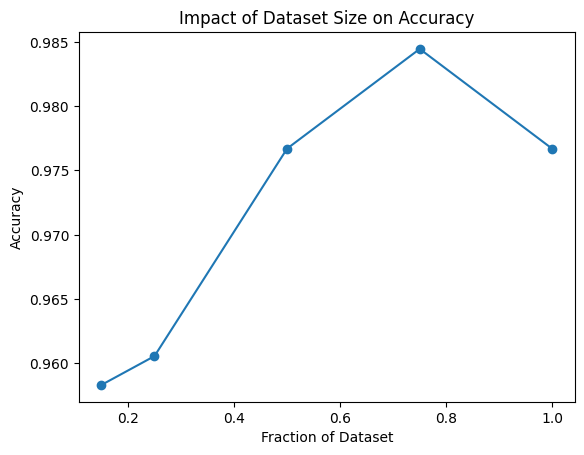

In [91]:
def downsampling_experiment(df, label_col, text_col, fractions, model, vectorizer, random_state=42):
    results = []
    
    for fraction in fractions:
        df_sampled = df.sample(frac=fraction, random_state=random_state)
        
        X_train, X_test, y_train, y_test = train_test_split(
            df_sampled[text_col], df_sampled[label_col], test_size=0.2, random_state=random_state
        )
        
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)
        
        model.fit(X_train_vec, y_train)
        
        y_pred = model.predict(X_test_vec)
        accuracy = accuracy_score(y_test, y_pred)
        
        results.append((fraction, accuracy))
        print(f"Fraction: {fraction}, Accuracy: {accuracy:.4f}")
    
    return results

fractions = [0.15, 0.25, 0.5, 0.75, 1.0]
vectorizer = CountVectorizer()
model = LogisticRegression(max_iter=1000)


results = downsampling_experiment(df_stemmed, label_col='label', text_col='text', fractions=fractions, model=model, vectorizer=vectorizer)

fractions, accuracies = zip(*results)
plt.plot(fractions, accuracies, marker='o')
plt.xlabel('Fraction of Dataset')
plt.ylabel('Accuracy')
plt.title('Impact of Dataset Size on Accuracy')
plt.show()
